In [1]:
#%pip install -q -r requirements-gpu.txt

In [2]:
#%pip install scikit-learn==0.22.1

# Определение возраста покупателей

**Задача**

>Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
>
>- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
>- Контролировать добросовестность кассиров при продаже алкоголя.
>
>**Постройте модель, которая по фотографии определит приблизительный возраст человека**. В вашем распоряжении набор фотографий людей с указанием возраста.

**Описание данных**

Данные взяты с сайта [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/dataset/26/description/). Они находятся в папке `/datasets/faces/`.
- Папка со всеми изображениями (`/final_files`) 
- csv-файл `labels.csv` с двумя колонками: *file_name* и *real_age*. 

## Исследовательский анализ данных

Импортируем необходимые библиотеки.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим CSV файл с целевыми признаками и сохраним его в переменную *labels*.

In [4]:
path = 'datasets/faces/'
labels = pd.read_csv(path + 'labels.csv')

### Возраст

Изображения загрузим методом *flow_from_dataframe*, укажем переменную *labels* и путь к папке с изображениями.

In [5]:
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


В наборе данных имеется 7591 изображение и соответствующий возраст. Максимальный возраст - 100, а минимальный - 1. Среднее значение возраста 31.2 года близко к медианному 29.

Построим график распределения возраста.

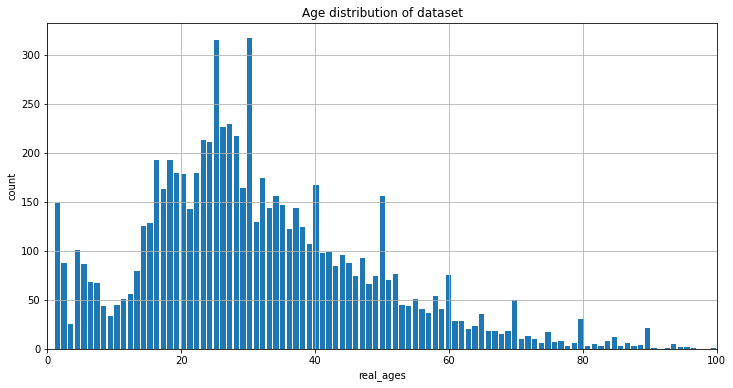

In [7]:
fig = plt.figure(figsize=(12,6))
labels['real_age'].plot(kind='hist', bins=100, rwidth=0.8, xlim=(0,100), grid=True)
plt.xlabel('real_ages')
plt.ylabel('count')
plt.title('Age distribution of dataset')
plt.show()

Глядя на график распределения, можно сделать ряд замечаний:
- Заметна некоторая бимодальность распределения: большое количество фотографий детей и остальная выборка.
- Среди возрастов относительно мало пожилых людей - модель может недостаточно хорошо обучиться для этой группы;
- Распределение возраста тяготеет к круглым значениям (30, 40...). 

### Изображения

Выведем на экран часть изображений и проверем как устроен датасет.

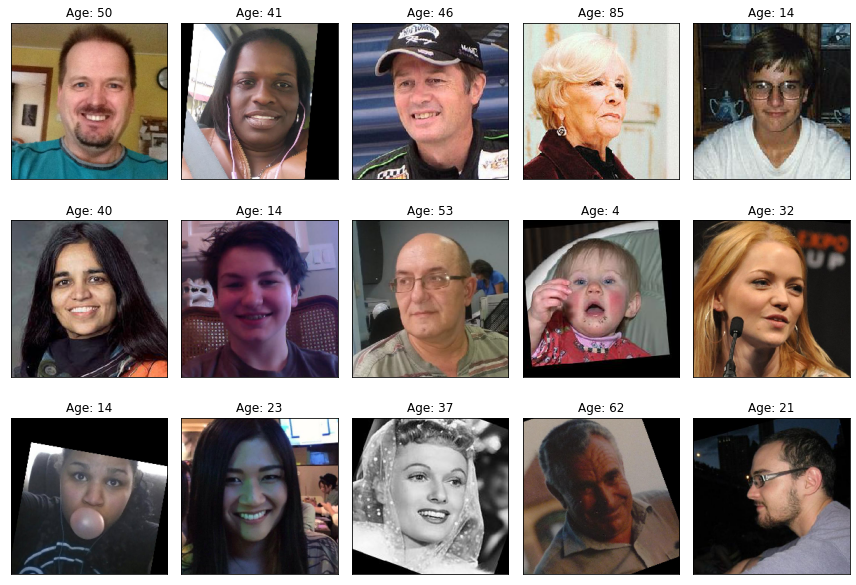

In [8]:
images, ages = next(datagen_flow)
fig = plt.figure(figsize=(12,9))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f'Age: {ages[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Следует отметить ряд особенностей набора изображений:
- Имеются старые и черно-белые фотографии;
- На части фотографий лица расположены под разными углами к вертикальной оси;
- Некоторые лица сфотографированы в полупрофиль;
- Разный масштаб лиц на фотографиях;
- На некоторых фотографиях люди сфотографированы полностью, лицо составляет малую часть изображения.

**Вывод**

Исходный набор данных разделен на целевой признак (возраст) и изображения. Изображения приведены к одинаковому размеру (224х224) и разделены на батчи по 32 изображения в загрузчике. 
- Распределение вораста имеет бимодальный характер. Имеем относительно небольшое число фотографий детей 8 - 12 лет. Также в наборе данных слабо представлены пожилые люди. Неравномерность распределения возрастов может привести к тому, что модель будет не одинаково хорошо предсказывать возраст для разных возрастных групп.
- Изображения имеют разного рода искажения - повороты, рамки, разный масштаб. Обучение на наборе данных с разлиными искажениями поможет модели лучше предсказывать возраст на различных фотографиях. Возможно имеет смысл дополнительно разнообразить набор данных с помощью аугментации - использовать отражения, повороты или изменения контрастности/яркости изображений.

## Обучение модели

Для предсказаний используем нейросеть на основе ResNet50. Процесс обучения оформлен в виде функций.

`load_train` - функция загрузки обучающей выборки. 
- Исходный датасет разделим на обучающий и тестовый в соотношении 70-30;
- Используем загрузчик данных ImageDataGenerator, который позволит загружать изображения постепенно небольшими группами. Это уменьшит потребность в объемах памяти;

`load_test` - функция загрузки тестовой выборки;
- Важно указывать одинаковые параметры `validation_split` и `seed`, чтобы разделение на обучающую и валидационные выборки происходило корректно.

`create_model` - создает модель и передает ей параметры.
- За основу возьмем модель ResNet50 из библиотеки Keras. Число 50 означает, что внутри модели находится 50 скрытых слоев.
- Чтобы вручную контролировать выход сети, уберем верхние слои, передав аргумент `include_top=False`. Верхушка состоит из пулинга и послносвязного слоя с одним нейроном и активацией ReLU;
- В аргумент `weights` модели ResNet50 передан путь к весам на сервере обучения. Это сделано для того, чтобы не загружать на сервер веса, а использовать уже предзагруженные. Веса аналогичны стандартным, предобученным на "imagenet".
В качестве последнего слоя использован полносвязный слой с одним нейроном, так как в результате требуется получить одно число, которое характеризует возраст. Использована активация ReLU, чтобы отсечь отрицательные значения. Качество контролируется метрикой MAE.

`train_model` - запускает процесс обучения модели. 
- Количество эпох - 10.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.3, rescale=1. / 255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.3, rescale=1. / 255)
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(lr=0.0001),
                  loss=MeanAbsoluteError(),
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```
Using TensorFlow backend.
Found 5314 validated image filenames.
Found 2277 validated image filenames.

Train for 167 steps, validate for 72 steps

Epoch 1/10
167/167 - 44s - loss: 237.5851 - mae: 11.0320 - val_loss: 717.3113 - val_mae: 21.9243
Epoch 2/10
167/167 - 37s - loss: 70.2587 - mae: 6.2909 - val_loss: 605.2190 - val_mae: 19.6505
Epoch 3/10
167/167 - 36s - loss: 35.0785 - mae: 4.5351 - val_loss: 615.7336 - val_mae: 19.9059
Epoch 4/10
167/167 - 37s - loss: 22.7660 - mae: 3.6352 - val_loss: 163.5744 - val_mae: 9.6154
Epoch 5/10
167/167 - 37s - loss: 20.6670 - mae: 3.3447 - val_loss: 94.5165 - val_mae: 7.3854
Epoch 6/10
167/167 - 36s - loss: 14.9701 - mae: 2.9823 - val_loss: 86.0899 - val_mae: 6.9925
Epoch 7/10
167/167 - 36s - loss: 10.5905 - mae: 2.4861 - val_loss: 78.0075 - val_mae: 6.8799
Epoch 8/10
167/167 - 37s - loss: 9.0821 - mae: 2.2935 - val_loss: 69.4119 - val_mae: 6.4622
Epoch 9/10
167/167 - 37s - loss: 7.1308 - mae: 2.0271 - val_loss: 69.0739 - val_mae: 6.4458
Epoch 10/10
167/167 - 36s - loss: 5.6610 - mae: 1.7998 - val_loss: 70.0474 - val_mae: 6.3127

72/72 - 11s - loss: 70.0474 - mae: 6.3127
Test MAE: 6.3127

```

## Анализ обученной модели

С помощью модели ResNet50 удалось получить ошибку на тестовой выборке 6,3 года, что меньше требуемых заказчиком 8 лет. Модель можно применять для предсказаний возраста человека по фотографии лица.